### Load Factor Prediction Model

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer


#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [2]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')

dataset['windgust'].replace(np.NaN, 0, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
dataset = dataset[dataset['loadFactor']<=1]
print(dataset['BMUID'].mode())
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y.shape)
print(X.shape)

print(y.mean())

print(dataset.describe())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=99)



0    ANSUW-1
Name: BMUID, dtype: object
(8042,)
(8042, 9)
0.30727223141928756
              temp      windspd     windgust  sealevelpressure   visibility  \
count  8042.000000  8042.000000  8042.000000       8042.000000  8042.000000   
mean      8.095722    11.198968    15.331137       1009.546817    19.119324   
std       4.729042     6.194097    19.450472         14.675464     8.279540   
min      -4.300000     0.000000     0.000000        952.700000     0.000000   
25%       4.400000     6.600000     0.000000        999.400000    12.725000   
50%       7.800000    10.200000     6.000000       1010.900000    19.500000   
75%      11.900000    14.800000    29.900000       1019.075000    25.200000   
max      25.300000    49.000000   114.100000       1050.100000    46.600000   

        cloudcover       precip          dew     humidity   loadFactor  
count  8042.000000  8042.000000  8042.000000  8042.000000  8042.000000  
mean     57.031286     0.057123     5.234506    83.208906     0.

#### Approaches

##### Linear Regression

In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

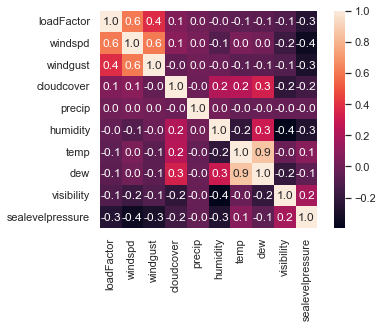

In [4]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True,
                      fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.
Below we scale & standardize the features, before running an evaluation of a set of different models to determine which performs best in our use case.
We here evaluate both linear and nonlinear models.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

print("Linear Models:\n")

potentialLinearModels = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', LassoCV()),
    ('ElasticNet', ElasticNet()),
    ('SGDRegressor', SGDRegressor()),
    ('SVM', SVR())
]

results = []
names = []
for name, model in potentialLinearModels:
    pipeline = Pipeline(
        steps=[('preprocessor', scaler), ('classifier', model)])
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold,scoring='neg_mean_squared_error',)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


print("\nNon-linear Models:\n")


potentialNonLinearModels = [
    ('DecisionTree Regressor', DecisionTreeRegressor()),
    ('KNN Regressor', KNeighborsRegressor()),
    ('GradBoost Regressor', GradientBoostingRegressor()),
    ('ADABoost Regressor', AdaBoostRegressor()),
    ('MLP Regressor', MLPRegressor()),
    ('XGBoost', xgb.XGBRegressor())
]


results = []
names = []
for name, model in potentialNonLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', scaler), ('classifier',
                                                          model)])
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(pipeline,
                                 X_train,
                                 y_train,
                                 cv=kfold,
                                 scoring='neg_mean_squared_error')
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    pipeline.fit(X_train,y_train)
    print(pipeline.score(X_test,y_test))


C:\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Linear Models:

Linear Regression: -0.050849 (0.002654)
Lasso: -0.050822 (0.002631)
ElasticNet: -0.082681 (0.000998)
SGDRegressor: -0.051101 (0.002611)
SVM: -0.048660 (0.002363)

Non-linear Models:

DecisionTree Regressor: -0.077864 (0.004810)
0.057160295513154935
KNN Regressor: -0.050909 (0.003210)
0.4010661735290455
GradBoost Regressor: -0.047202 (0.002448)
0.4053342232975641
ADABoost Regressor: -0.053088 (0.003135)
0.3485522466118731
MLP Regressor: -0.048437 (0.001632)
0.4102789561514619
XGBoost: -0.046890 (0.001633)
0.4185327841905294


Here we see some not ideal performance results and we find that when using our test dataset, the best scoring models (MLP,gradBoost) achieve roughly 0.18-19% mean error, and .14% standard deviation.
